In [1]:
import os
import glob
import json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
filename_base = "/home/jpivarski/storage/data/dependent-repos-of-numba-2/categorized/pypi-strict/"

categorized_pypi = {level: {} for level in range(1, 9)}
for level in range(1, 9):
    for filename in glob.glob(f"{filename_base}/level-{level}/*.json"):
        package_name = filename.split("/")[-1][:-5]

        with open(filename) as file:
            data = json.load(file)

        counter = Counter()
        for choice in data["choices"]:
            c = choice["message"]["content"]
            if c["type"] == "object" and "properties" in c:
                c = c["properties"]
            elif c["type"] == "object" and "parameters" in c:
                c = c["parameters"]

            s = c.get("other (if not in list above)")
            if s is None:
                s = c.get("Other (if not in list above)")
            if s is None:
                s = c.get("other")
            if s is None:
                s = c.get("Other")
            if s is None:
                if "subject" not in c and "properties" in c:
                    s = c["properties"]["subject"]
                else:
                    s = c["subject"]

            counter[s, c["type"]] += c["confidence"]
        
        (subject, project_type), _ = sorted(counter.items(), key=lambda x: -x[1])[0]
        categorized_pypi[level][package_name] = (subject, project_type)

In [3]:
filename_base = "/home/jpivarski/storage/data/dependent-repos-of-numba-2/categorized/github-again/"

categorized_github = {}
for filename in glob.glob(f"{filename_base}/*/*.json"):
    repo_name = "/".join(filename.split("/")[-2:])[:-5]

    with open(filename) as file:
        data = json.load(file)

    counter = Counter()
    for choice in data["choices"]:
        c = choice["message"]["content"]
        if c["type"] == "object" and "properties" in c:
            c = c["properties"]

        s = c.get("other (if not in list above)")
        if s is None:
            s = c.get("Other (if not in list above)")
        if s is None:
            s = c.get("other")
        if s is None:
            s = c.get("Other")
        if s is None:
            s = c["subject"]

        t = c.get("type")
        if t is None:
            t = "Unknown"

        counter[s, t] += c["confidence"] if "confidence" in c else 0
    
    (subject, project_type), _ = sorted(counter.items(), key=lambda x: -x[1])[0]
    categorized_github[repo_name] = (subject, project_type)

In [4]:
project_types = [
    "Academic Research",
    "Commercial/Industrial Research",
    "Commercial/Industrial Engineering",
    "Non-Profit",
    "Personal Project",
    "Student Project or Homework",
]

counter = Counter()
for level in range(1, 9):
    for subject, project_type in categorized_pypi[level].values():
        counter[subject] += 1

for subject, project_type in categorized_github.values():
    counter[subject] += 1

subjects = [x[0] for x in sorted(counter.items(), key=lambda x: x[1])[-30:]]

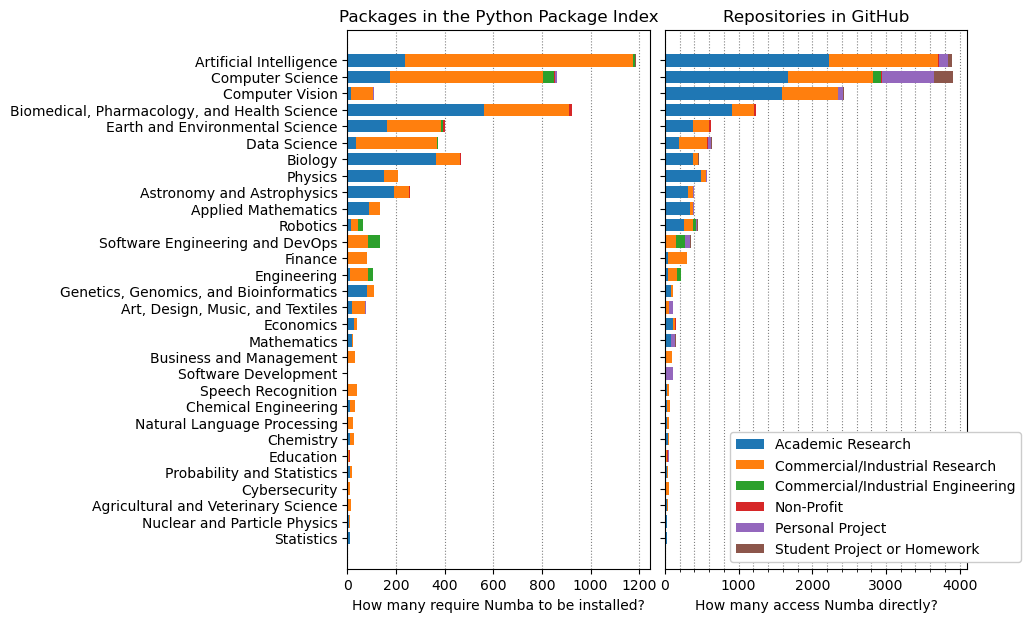

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))

def plot_pypi(ax):
    counter = Counter()
    for level in range(1, 9):
        for subject, project_type in categorized_pypi[level].values():
            if subject in subjects:
                counter[subject, project_type] += 1
    
    weight_counts = {project_type: np.zeros(len(subjects)) for project_type in project_types}
    
    for i, subject in enumerate(subjects):
        for project_type in project_types:
            weight_counts[project_type][i] = counter.get((subject, project_type), 0)
    
    left = np.zeros(len(subjects))
    for project_type, weight_count in weight_counts.items():
        ax.barh(subjects, weight_count, 0.75, label=project_type, left=left)
        left += weight_count
    
    ax.set_axisbelow(True)
    ax.grid(axis="x", color="gray", ls=":")
    
    ax.set_title("Packages in the Python Package Index")
    ax.set_xlabel("How many require Numba to be installed?")

def plot_github(ax):
    counter = Counter()
    for subject, project_type in categorized_github.values():
        if subject in subjects:
            counter[subject, project_type] += 1
    
    weight_counts = {project_type: np.zeros(len(subjects)) for project_type in project_types}
    
    for i, subject in enumerate(subjects):
        for project_type in project_types:
            weight_counts[project_type][i] = counter.get((subject, project_type), 0)
    
    left = np.zeros(len(subjects))
    for project_type, weight_count in weight_counts.items():
        ax.barh(subjects, weight_count, 0.75, label=project_type, left=left)
        left += weight_count
    
    ax.legend(loc="lower right", bbox_to_anchor=(1.2, 0), framealpha=1)
    ax.set_axisbelow(True)
    ax.grid(which="both", axis="x", color="gray", ls=":")
    
    ax.set_title("Repositories in GitHub")
    ax.set_xlabel("How many access Numba directly?")
    ax.set_xticks(range(0, 4200, 200), minor=True)
    ax.set_yticklabels([])

plot_pypi(ax1)
plot_github(ax2)

plt.subplots_adjust(wspace=0.05)

fig.savefig("impact-of-numba.svg")